<a href="https://colab.research.google.com/github/mansilal15/Transfer_Learning_Using_MobileNet/blob/master/Transfer_Learning_Using_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
from keras.applications import MobileNet
img_rows, img_cols = 224, 224 
MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

#this will freeze all the layers of existing model and 
for layer in MobileNet.layers:
    layer.trainable = False

17227776/17225924 [==============================] - 2s 0us/step


In [4]:
MobileNet.layers

In [0]:
def adding_our_layers_of_nn(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# as we have 2 personalities to be trained
num_classes = 2

FC_Head = adding_our_layers_of_nn(MobileNet, num_classes)
model = Model(inputs = MobileNet.input, outputs = FC_Head)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/My Drive/Colab Notebooks/transfer_learning_drive/my_dataset/training_data_for_model'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/transfer_learning_drive/my_dataset/valid_data_for_model'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale= 1./255)
 
# set our batch size (typically on most mid-tier systems we'll use 16-32)
batch_size = 16
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 28 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [8]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
               
checkpoint = ModelCheckpoint("js_mobileNet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.0001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 1097
nb_validation_samples = 272

# We only train 5 EPOCHS 
epochs = 4
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/4
68/68 [==============================] - 38s 562ms/step - loss: 0.0723 - accuracy: 0.9706 - val_loss: 0.0451 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.04509, saving model to js_mobileNet.h5
Epoch 2/4
68/68 [==============================] - 19s 282ms/step - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.0201 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.04509 to 0.02014, saving model to js_mobileNet.h5
Epoch 3/4
68/68 [==============================] - 20s 294ms/step - loss: 0.1051 - accuracy: 0.9874 - val_loss: 0.0175 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.02014 to 0.01750, saving model to js_mobileNet.h5
Epoch 4/4
68/68 [==============================] - 20s 291ms/step - loss: 0.0318 - accuracy: 0.9926 - val_loss: 0.0105 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.01750 to 0.01047, saving model to js_mobileNet.h5


In [0]:
from keras.models import load_model
classifier = load_model('js_mobileNet.h5')

In [0]:
#the image to be predicted
img='/content/drive/My Drive/Colab Notebooks/transfer_learning_drive/my_dataset/training_data_for_model/js/js2.jpg'

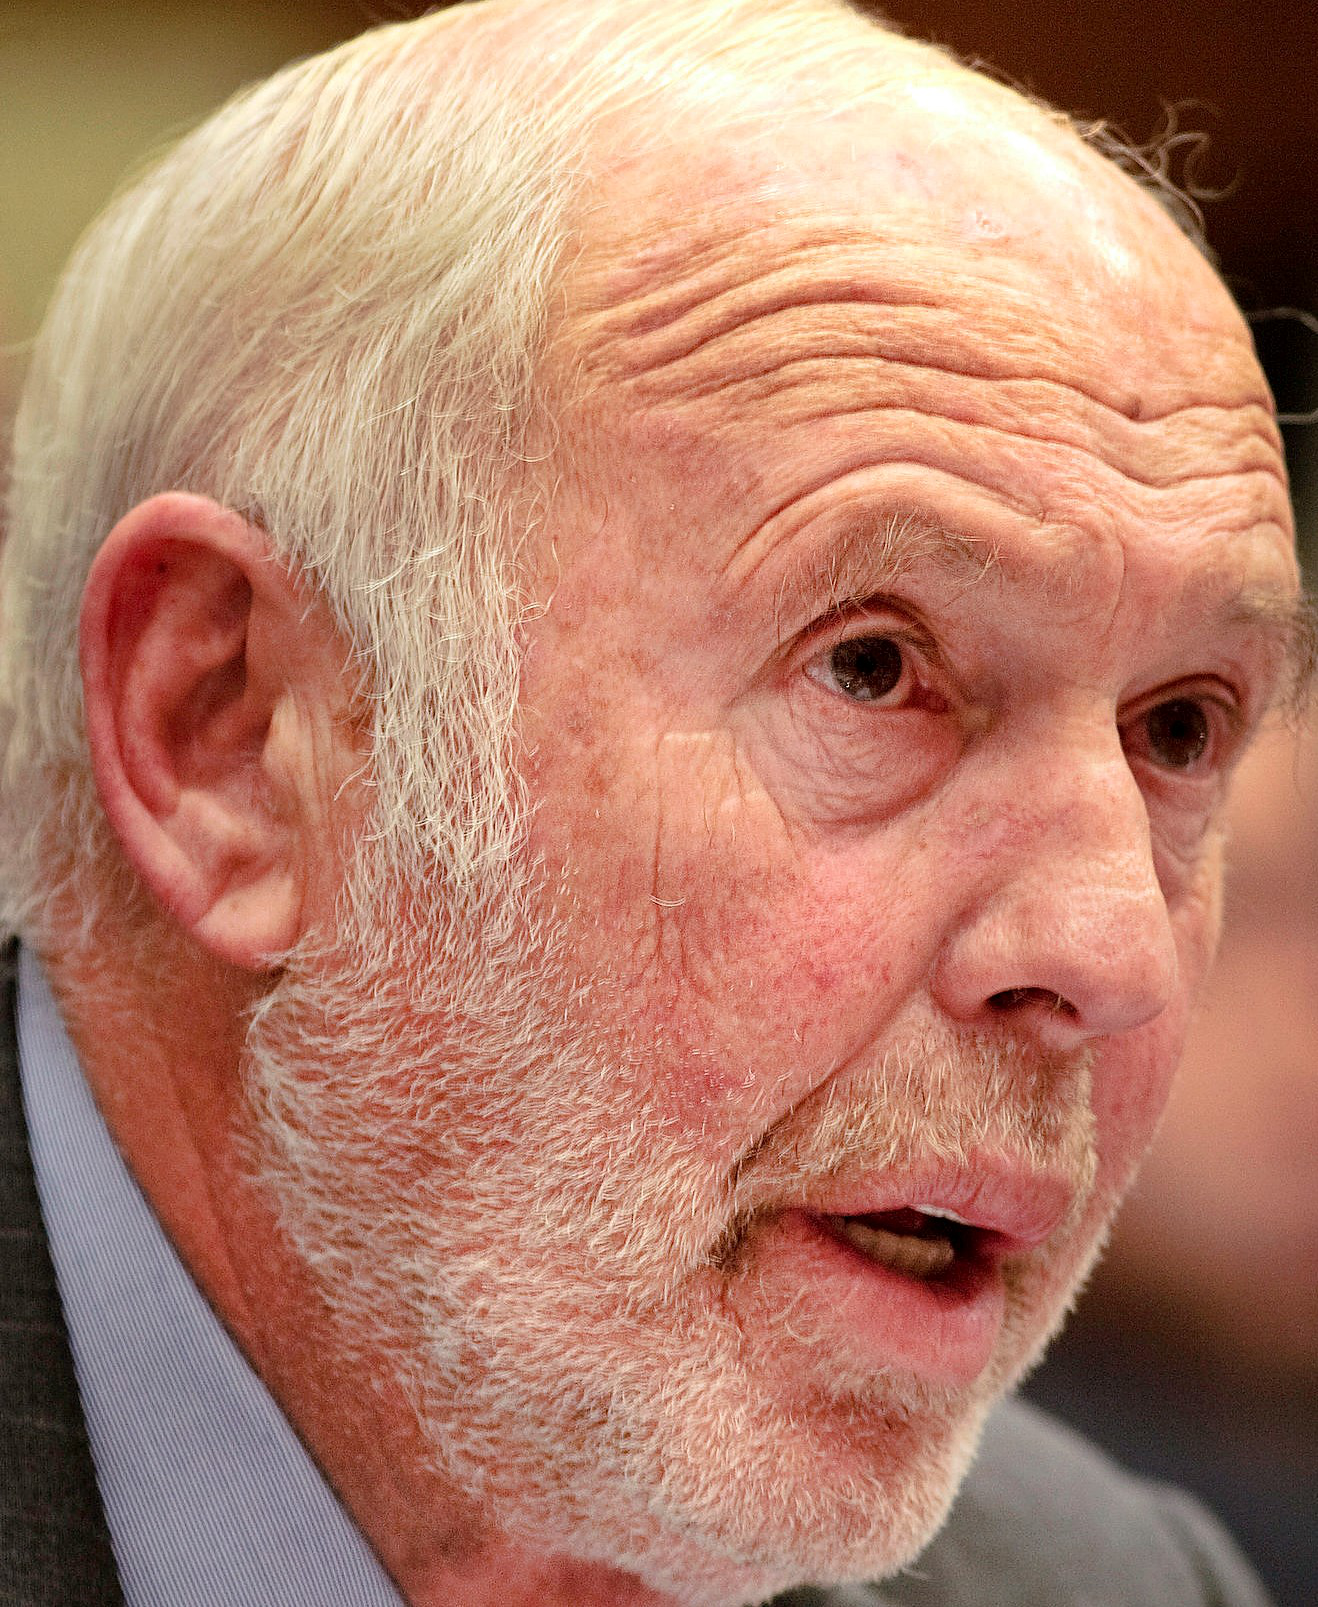

In [11]:
import cv2
from PIL import Image               # to load images
from IPython.display import display # to display images

input_im = cv2.imread(img) 
pil_im = Image.open(img)
display(pil_im)

In [12]:
import numpy as np
input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
input_im = input_im / 255.
input_im = input_im.reshape(1,224,224,3)
perc = classifier.predict(input_im, 1, verbose = 0)*100
res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)

if(res[0] == 0 and perc[0][0]>85):
    print("Jim Simons")
elif(res[0] == 1 and perc[0][1]>85):
    print("Warren Buffet")
else:
    print("None of them...")
    
print("Possibility of Jim Simons: ", np.format_float_positional(perc[0][0], trim='-'), " %")  
print("Possibility of Warren Buffet: ", np.format_float_positional(perc[0][1], trim='-'), " %")
            

Jim Simons
Possibility of Jim Simons:  99.31519  %
Possibility of Warren Buffet:  0.68480504  %
